In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = tf.one_hot(y_train, depth=10).numpy()
y_test = tf.one_hot(y_test, depth=10).numpy()
# mnist画像直列化
x_test.shape

(10000, 28, 28)

In [ ]:
import numpy as np
# 元の画像を10個のラベル事に整理
nte = 500
test_high = []
for i in range(10):
    idx = np.where(y_test[:, i] == 1)[0]
    test_high.append(x_test[idx[-nte:], :])
test_high = np.array(test_high)
print(test_high.shape)

(10, 500, 28, 28)


In [ ]:
# ガウスカーネル
size=9
s=1.3
width = int(size//2)
a = np.abs(np.arange(-width, width+1)[:, np.newaxis])
dist = a**2 + (a**2).T
kernel = np.exp(-dist / (2 * s**2)) / (2 * np.pi * s)

In [ ]:
from scipy.signal import fftconvolve
test_low = []
# 低解像度の画像の準備
for i in range(test_high.shape[0]):
    blured_imgs_per_label = []
    for j in range(test_high.shape[1]):
        high_img = test_high[i, j].reshape(28, 28)
        blured_img = fftconvolve(high_img, kernel[::-1, ::-1], mode='same')
        blured_imgs_per_label.append(blured_img)
    test_low.append(blured_imgs_per_label)
test_low = np.array(test_low)
print(test_low.shape)

(10, 500, 28, 28)


### ISTA
$ \hat{x} = {\rm argmin} \frac{1}{2} \| b - kernel \ast x\| + \lambda \| x \|_1$  
$ g_t = A^T (A x_{t -1} - b)$  
$ x_t = S_{\eta \lambda}(x_{t - 1} - \eta g_t) = S_{\eta \lambda} ((I - A^T A ) x_{t -1} + A^T A b)$

In [ ]:
from scipy.signal import fftconvolve
def objective_func(a, z, x, rho):
    return 0.5 * np.sum((fftconvolve(z, a, mode='same') - x)**2) + rho * np.sum(np.abs(z)) 

def ista(a, x, rho=0.1, max_iter=500, tol=1e-5):
    rho *= 784
    eta = 0.1  # バックトラックで決める
    c = 0.01
    z = np.zeros((28, 28))
    obj = objective_func(a, z, x, rho)
    for itr in range(max_iter):
        gi = fftconvolve(fftconvolve(z, a[::-1, ::-1], mode='same') - x, a, mode='same')
        delta = np.sum(np.dot(gi.T, -gi))
        while objective_func(a, z - eta * gi, x, rho) > objective_func(a, z, x, rho) + c*eta*delta:
            eta = 0.1 * eta
        zi = z - eta * gi
        # ReLU
        z_new = np.sign(zi) * np.maximum(0.0, np.abs(zi) - rho * eta)
        z_new = np.maximum(0.0, z_new)
        obj_new = objective_func(a, z_new, x, rho)
        z = z_new
        if obj - obj_new < tol:
            break
        obj = obj_new
    return z

In [ ]:
def recover(low_imgs, kernel, rho=1e-2):
    recovered = []
    for i in range(low_imgs.shape[0]):
        print(i)
        yi = []
        for j in range(low_imgs.shape[1]):
            yij = ista(kernel, low_imgs[i, j, :], rho=rho, max_iter=500)
            yi.append(yij)
        recovered.append(yi)
    return np.array(recovered)

0
1
2
3
4
5
6
7
8
9
(10, 500, 28, 28)


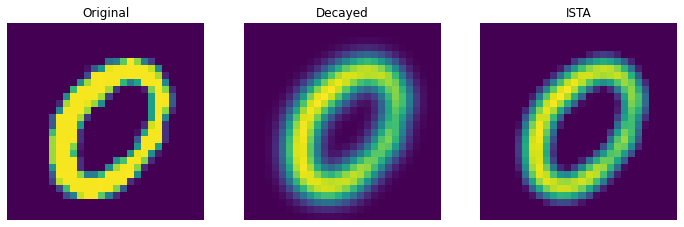

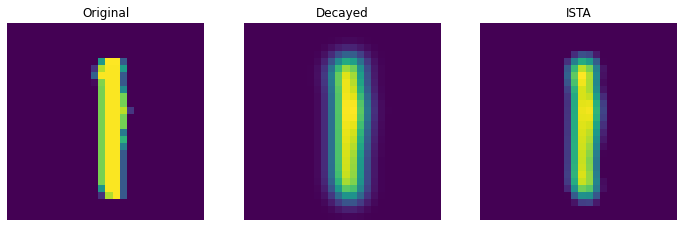

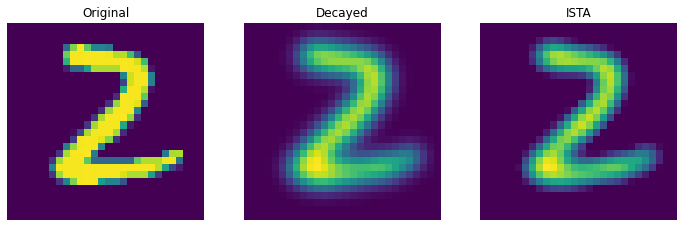

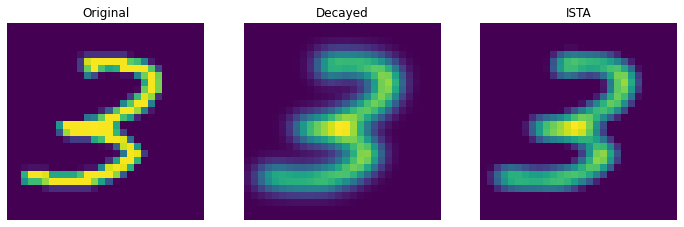

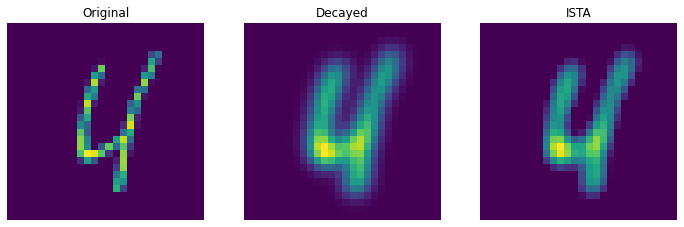

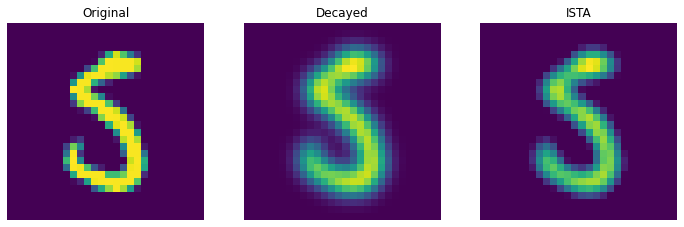

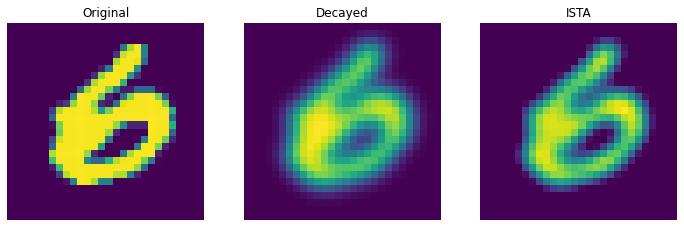

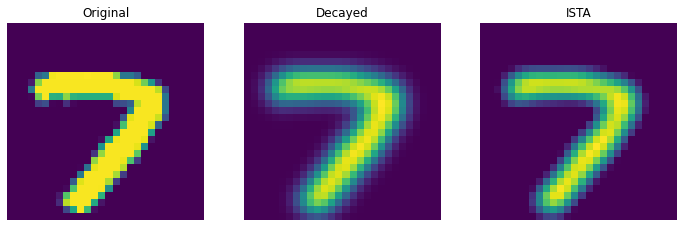

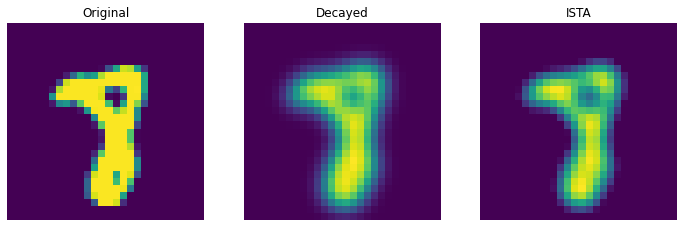

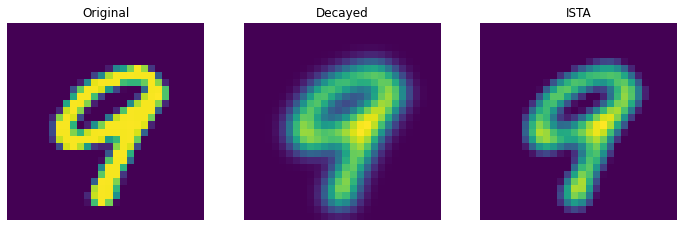

In [ ]:
from matplotlib import pyplot as plt
recovered_imgs = recover(test_low, kernel)
print(recovered_imgs.shape)

# examples of recovered images
j = 12
for i in range(recovered_imgs.shape[0]):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(test_high[i, j, :].reshape((28, 28)))
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(test_low[i, j, :].reshape((28, 28)))
    plt.title('Decayed')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(recovered_imgs[i, j, :].reshape((28, 28)))
    plt.title('ISTA')
    plt.axis('off')
    plt.show()